In [2]:
import wandb

wandb.login()


True

In [ ]:
import wandb

import jax
import jax.numpy as jnp
from jax.lax import fori_loop, cond, scan
from jax import vmap, jit
from scipy.sparse import csc_matrix, identity
from scipy.sparse.linalg import cg, gmres
import math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import time


#Create mesh

r_earth = 6400.0  # in km; wavenumbers will be in 1/km
Lx = 1000  # km      Use 1020 and 1022 for dxm=4 and 2.
Ly = Lx
dxm = 5
dym = dxm
cyclic = 0  # 1 if mesh is cyclic
cyclic_length = 360  # in degrees; if not cyclic, take it larger than  zonal size
cyclic_length = cyclic_length * math.pi / 180  # DO NOT TOUCH
meshtype = 'm'  # coordinates can be in physical measure 'm' or in radians 'r'
cartesian = True

xx = np.arange(0, Lx + 1, dxm, dtype="float32")
yy = np.arange(0, Ly + 1, dym, dtype="float32")

# Create uniformity in the mesh
# xx = np.concatenate((np.arange(0, 4*Lx//20 + 1, dxm), np.arange(5*Lx//20, Lx + 1, dxm)))
# yy = np.concatenate((np.arange(0, 4*Ly//20 + 1, dym), np.arange(5*Ly//20, Ly + 1, dym)))

nx = len(xx)
ny = len(yy)

nodnum = np.arange(0, nx * ny)
xcoord = np.tile(xx, reps=(ny, 1)).T
ycoord = np.tile(yy, reps=(nx, 1))

#Create random data with given spectra

@jit
def make_ll(x, y):
    return jnp.sqrt(y * y + x * x)

@jit
def make_tff(ttf, ll):
    return ttf / (jnp.power(ll, 1.5))  # 1.5 for -2 spectrum

tt = 50 * (np.random.random(xcoord.shape) - 0.5)
ttf = np.fft.fft2(tt)
# ============
# Make spectrum red
# ============
espectrum = np.zeros((nx // 2 + 1))  # Place for Fourier spectrum
kk = np.concatenate((np.arange(0, nx // 2 + 1), np.arange(-nx // 2 + 1, 0, 1)))  # Wavenumbers

ll = vmap(vmap(make_ll, in_axes=(None, 0)), in_axes=(0, None))(kk, kk)
ttf = vmap(vmap(make_tff, in_axes=(0, 0)), in_axes=(0, 0))(ttf, ll)
ttf = ttf.at[0, 0].set(0.0)

tt = jnp.real(jnp.fft.ifft2(ttf))

# == == == == == == == =
# Reshape to 1D arrays
# == == == == == == == =
nodnum = np.reshape(nodnum, [ny, nx]).T
xcoord = np.reshape(xcoord, [nx * ny])
ycoord = np.reshape(ycoord, [nx * ny])
tt = np.reshape(tt, [nx * ny])

#Convert mesh and data to spherical geometry

cartesian = False

xcoord /= r_earth
ycoord /= r_earth
alpha = math.pi/3 + math.pi/12
zg = np.sin(ycoord)
xg = np.cos(ycoord) * np.cos(xcoord)
yg = np.cos(ycoord) * np.sin(xcoord)
# Rotate by alpha
zn = zg * np.cos(alpha) + xg * np.sin(alpha)
xg = -zg * np.sin(alpha) + xg * np.cos(alpha)
# New coordinates in radians
ycoord = np.arcsin(zn)
xcoord = np.arctan2(yg,xg)
# New coordinates in degrees
ycoord = (180/math.pi) * np.arcsin(zn)
xcoord = (180/math.pi) * np.arctan2(yg,xg)

#Create Triangulation

def make_tri(nodnum: jnp.ndarray, nx: int, ny: int):
    def make_tri(n, nn):
        return jnp.array([nodnum[nn, n], nodnum[nn+1, n], nodnum[nn, n+1]]), jnp.array([nodnum[nn+1, n], nodnum[nn+1, n+1], nodnum[nn, n+1]])

    b = jnp.reshape(vmap(lambda i: jnp.tile(i, nx-1))(jnp.arange(ny-1)), [(nx-1)*(ny-1)])
    a = jnp.tile(jnp.arange(nx-1), nx-1)

    tri = vmap(make_tri)(b, a)
    return jnp.reshape(jnp.concatenate((tri[0], tri[1]), axis=1), [2*(nx-1)*(ny-1), 3])

make_tri = jit(make_tri, static_argnums=[1, 2])

tri = make_tri(nodnum, nx, ny)
tri = np.array(tri)
n2d = len(xcoord)  # The number of vertices(nodes)
e2d = len(tri[:, 1])  # The number of triangles(elements)

tri

# Create auxilliary arrays for the 


def neighboring_triangles(n2d: int, e2d: int, tri: np.ndarray):
    """
    Calculate neighboring triangles for each node in a 2D mesh.

    Parameters:
    ----------
    n2d : int
        The total number of nodes in the mesh.

    e2d : int
        The total number of triangles (elements) in the mesh.

    tri : np.ndarray
        A 2D NumPy array representing the connectivity of triangles (elements) in the mesh.
        Each row contains the indices of the three nodes that form a triangle.

    Returns:
    -------
    ne_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the count of neighboring triangles for each node.

    ne_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_triangles, n2d) containing the positions of neighboring
        triangles for each node. The 'ne_pos[i, j]' entry indicates the index of the i-th neighboring triangle
        for the j-th node. Unused entries are filled with zeros.
    """
    # Initialize an array to store the count of neighboring triangles for each node.
    ne_num = np.zeros([n2d], dtype=int)

    # Loop through each triangle (element) in the mesh.
    for n in range(e2d):
        enodes = tri[n, :]
        # Increment the count of neighboring triangles for each node in the current triangle.
        ne_num[enodes] += 1

    # Initialize an array to store the positions of neighboring triangles for each node.
    ne_pos = np.zeros([int(np.max(ne_num)), n2d], dtype=int)

    # Reset the array to store the count of neighboring triangles for each node.
    ne_num = np.zeros([n2d], dtype=int)

    # Loop through each triangle (element) in the mesh.
    for n in range(e2d):
        enodes = tri[n, :]
        # Loop through the nodes of the current triangle.
        for j in range(3):
            # Store the position of the current neighboring triangle for the corresponding node.
            ne_pos[ne_num[enodes[j]], enodes[j]] = n
            # Increment the count of neighboring triangles for the node.
        ne_num[enodes] += 1

    return ne_num, ne_pos

def neighbouring_nodes(n2d: int, tri: np.ndarray, ne_num: np.ndarray, ne_pos: np.ndarray):
    """
    Compute neighboring nodes for each node in a 2D mesh.

    Parameters:
    ----------
    n2d : int
        The total number of nodes in the mesh.

    tri : np.ndarray
        A 2D NumPy array representing the connectivity of triangles (elements) in the mesh.
        Each row contains the indices of the three nodes that form a triangle.

    ne_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the count of neighboring triangles for each node.

    ne_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_triangles, n2d) containing the positions of neighboring
        triangles for each node. The 'ne_pos[i, j]' entry indicates the index of the i-th neighboring triangle
        for the j-th node. Unused entries are filled with zeros.

    Returns:
    -------
    nn_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the number of neighboring nodes for each node.

    nn_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_nodes, n2d) containing the positions of neighboring nodes
        for each node. The 'nn_pos[i, j]' entry indicates the index of the i-th neighboring node for the j-th node.
    """
    # Initialize an array to store the count of neighboring nodes for each node.


    # Initialize an array to store the positions of neighboring nodes for each node.
    nn_num = np.zeros([n2d], dtype=int)
    check = np.zeros([n2d], dtype=int)
    aux = np.zeros([10], dtype=int)
    for j in range(n2d):
        cc = 0
        for m in range(ne_num[j]):
            el = ne_pos[m, j]
            for k in range(3):
                a = tri[el, k]
                if check[a] == 0:
                    check[a] = 1
                    aux[cc] = a
                    cc += 1

        nn_num[j] = cc
        check[aux[0:cc]] = 0

    nn_pos = np.zeros([np.max(nn_num), n2d], dtype=int)

    for j in range(n2d):
        cc = 0
        for m in range(ne_num[j]):
            el = ne_pos[m, j]
            for k in range(3):
                a = tri[el, k]
                if check[a] == 0:
                    check[a] = 1
                    aux[cc] = a
                    cc += 1

        nn_pos[0:cc, j] = aux[0:cc].T
        check[aux[0:cc]] = 0

    return nn_num, nn_pos

def areas(n2d: int, e2d: int, tri: np.ndarray, xcoord: np.ndarray, ycoord: np.ndarray, ne_num: np.ndarray,
          ne_pos: np.ndarray, meshtype: str, carthesian: bool, cyclic_length):
    """
    Calculate areas of triangles and derivatives of P1 basis functions.

    Parameters:
    ----------
    n2d : int
        The total number of nodes in the mesh.

    e2d : int
        The total number of triangles (elements) in the mesh.

    tri : np.ndarray
        A 2D NumPy array representing the connectivity of triangles (elements) in the mesh.
        Each row contains the indices of the three nodes that form a triangle.

    xcoord : np.ndarray
        A 1D NumPy array containing the x-coordinates of nodes in the mesh.

    ycoord : np.ndarray
        A 1D NumPy array containing the y-coordinates of nodes in the mesh.

    ne_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the count of neighboring triangles for each node.

    ne_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_triangles, n2d) containing the positions of neighboring
        triangles for each node. The 'ne_pos[i, j]' entry indicates the index of the i-th neighboring triangle
        for the j-th node. Unused entries are filled with zeros.

    meshtype : str
        Mesh type, either 'm' (metric) or 'r' (radial).

    carthesian : bool
        Boolean indicating whether the mesh is in Cartesian coordinates.

    cyclic_length : float
        The length of the cyclic boundary if the mesh is cyclic (for 'r' meshtype).

    Returns:
    -------
    area : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the scalar cell (cluster) area for each node.

    elem_area : np.ndarray
        A 1D NumPy array of shape (e2d,) containing the area of each triangle (element) in the mesh.

    dx : np.ndarray
        A 2D NumPy array of shape (e2d, 3) containing the x-derivative of P1 basis functions for each triangle.

    dy : np.ndarray
        A 2D NumPy array of shape (e2d, 3) containing the y-derivative of P1 basis functions for each triangle.

    Mt : np.ndarray
        A 1D NumPy array of shape (e2d,) containing a factor for metric terms based on meshtype and coordinates.
    """
    dx = np.zeros([e2d, 3], dtype=float)
    dy = np.zeros([e2d, 3], dtype=float)
    elem_area = np.zeros([e2d])
    r_earth = 6400  # Earth's radius, assuming units in kilometers
    Mt = np.ones([e2d])

    if meshtype == 'm':
        for n in range(e2d):
            # Calculate differences in x and y coordinates for triangle vertices.
            x2 = xcoord[tri[n, 1]] - xcoord[tri[n, 0]]
            x3 = xcoord[tri[n, 2]] - xcoord[tri[n, 0]]
            y2 = ycoord[tri[n, 1]] - ycoord[tri[n, 0]]
            y3 = ycoord[tri[n, 2]] - ycoord[tri[n, 0]]

            # Calculate determinant of the Jacobian matrix for this triangle.
            d = x2 * y3 - y2 * x3

            # Calculate x and y derivatives of P1 basis functions.
            dx[n, 0] = (-y3 + y2) / d
            dx[n, 1] = y3 / d
            dx[n, 2] = -y2 / d

            dy[n, 0] = -(-x3 + x2) / d
            dy[n, 1] = -x3 / d
            dy[n, 2] = x2 / d

            # Calculate the area of the triangle.
            elem_area[n] = 0.5 * abs(d)

    elif meshtype == 'r':
        rad = math.pi / 180.0
        if carthesian:
            Mt = np.ones([e2d])
        else:
            Mt = np.cos(np.sum(rad * ycoord[tri], axis=1) / 3.0)

        for n in range(e2d):
            # Calculate differences in longitude and latitude for triangle vertices.
            x2 = rad * (xcoord[tri[n, 1]] - xcoord[tri[n, 0]])
            x3 = rad * (xcoord[tri[n, 2]] - xcoord[tri[n, 0]])
            y2 = r_earth * rad * (ycoord[tri[n, 1]] - ycoord[tri[n, 0]])
            y3 = r_earth * rad * (ycoord[tri[n, 2]] - ycoord[tri[n, 0]])

            # Adjust for cyclic boundaries.
            if x2 > cyclic_length / 2.0:
                x2 = x2 - cyclic_length
            if x2 < -cyclic_length / 2.0:
                x2 = x2 + cyclic_length
            if x3 > cyclic_length / 2.0:
                x3 = x3 - cyclic_length
            if x3 < -cyclic_length / 2.0:
                x3 = x3 + cyclic_length

            # Apply metric factors and calculate x and y derivatives of P1 basis functions.
            x2 = r_earth * x2 * Mt[n]
            x3 = r_earth * x3 * Mt[n]
            d = x2 * y3 - y2 * x3

            dx[n, 0] = (-y3 + y2) / d
            dx[n, 1] = y3 / d
            dx[n, 2] = -y2 / d

            dy[n, 0] = -(-x3 + x2) / d
            dy[n, 1] = -x3 / d
            dy[n, 2] = x2 / d

            # Calculate the area of the triangle.
            elem_area[n] = 0.5 * abs(d)

        if carthesian:
            Mt = np.zeros([e2d])
        else:
            Mt = (np.sin(rad * np.sum(ycoord[tri], axis=1) / 3.0) / Mt) / r_earth

    # Calculate scalar cell (cluster) area for each node.
    area = np.zeros([n2d])
    for n in range(n2d):
        area[n] = np.sum(elem_area[ne_pos[0:ne_num[n], n]]) / 3.0

    return area, elem_area, dx, dy, Mt

ne_num, ne_pos = neighboring_triangles(n2d, e2d, tri)
nn_num, nn_pos = neighbouring_nodes(n2d, tri, ne_num, ne_pos)
area, elem_area, dx, dy, Mt = areas(n2d, e2d, tri, xcoord, ycoord, ne_num, ne_pos, meshtype, cartesian, cyclic_length)

Kc = np.array([2, 2.2, 2.5, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 30, 40, 60, 80, 100]) * dxm
Kc = 2 * math.pi / Kc  # Wavenumbers
nr = len(Kc)

# Move data to JAX
jKc = jnp.array(Kc)
jescaling = jnp.zeros([nr + 1])  # Place for spectrum
# # Compute total energy
jescaling.at[0].set(jnp.sum(area * jnp.square(tt)) / jnp.sum(area))
jelem_area = jnp.array(elem_area)
jdx = jnp.array(dx)
jdy = jnp.array(dy)
jnn_num = jnp.array(nn_num)
jnn_pos = jnp.array(nn_pos)
jtri = jnp.array(tri)
jarea = jnp.array(area)
jMt = jnp.array(Mt)
jtt = jnp.array(tt)

# Create Laplacian matrix

def make_smooth(Mt: jnp.ndarray, elem_area: jnp.ndarray, dx: jnp.ndarray, dy: jnp.ndarray, nn_num: jnp.ndarray,
                nn_pos: jnp.ndarray, tri: jnp.ndarray, n2d: int, e2d: int, full: bool = False):
    """
    Calculate the smoothness matrix and metric matrix for a given mesh.

    WARNING!!! This function is inherently single-threaded!. Running it on GPU will cause performance issue

    Parameters:
    ----------
    Mt : jnp.ndarray
        A 1D JAX NumPy array containing metric factors for each triangle.

    elem_area : jnp.ndarray
        A 1D JAX NumPy array containing the area of each triangle.

    dx : jnp.ndarray
        A 2D JAX NumPy array of shape (e2d, 3) containing x-derivatives of P1 basis functions.

    dy : jnp.ndarray
        A 2D JAX NumPy array of shape (e2d, 3) containing y-derivatives of P1 basis functions.

    nn_num : jnp.ndarray
        A 1D JAX NumPy array of shape (n2d,) containing the number of neighboring nodes for each node.

    nn_pos : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing positions of neighboring nodes.

    tri : jnp.ndarray
        A 2D JAX NumPy array representing the connectivity of triangles in the mesh.

    n2d : int
        The total number of nodes in the mesh.

    e2d : int
        The total number of triangles (elements) in the mesh.

    full : bool, optional
        A flag indicating whether to use the 'full' calculation including metric factors (True) or not (False).
        Default is True.

    Returns:
    -------
    smooth_m : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing the smoothness matrix.

    metric : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing the metric matrix.
    """
    smooth_m = jnp.zeros(nn_pos.shape, dtype=jnp.float32)
    metric = jnp.zeros(nn_pos.shape, dtype=jnp.float32)
    aux = jnp.zeros((n2d,), dtype=jnp.int32)

    @jit
    def loop_body(j, carry):
        smooth_m, metric, aux, nn_num, nn_pos, elem_area, dx, dy, Mt = carry
        enodes = tri[j, :]

        def inner_loop_body(n, carry):
            smooth_m, metric, aux, enodes, nn_num, nn_pos, elem_area, dx, dy, Mt = carry
            row = enodes[n]
            cc = nn_num[row]

            def fill_xd(i, val):
                row, aux, nn_pos = val
                n = nn_pos[i, row]
                aux = aux.at[n].set(i)
                return row, aux, nn_pos

            row, aux, _ = fori_loop(0, cc, fill_xd, (row, aux, nn_pos))

            def update_smooth_m(m, carry):
                smooth_m, metric, aux, enodes, elem_area, dx, dy, n = carry
                col = enodes[m]
                pos = aux[col]
                tmp_x = dx[m] * dx[n]
                tmp_y = dy[n] * dy[m]
                c1 = m == n

                smooth_m = smooth_m.at[pos, row].add(cond(c1 & full,
                                                          lambda: (tmp_x + tmp_y) * elem_area + jnp.square(
                                                              Mt) * elem_area / 3.0,
                                                          lambda: (tmp_x + tmp_y) * elem_area
                                                          )
                                                     )
                metric = metric.at[pos, row].add(Mt * (dx[n] - dx[m]) * elem_area / 3.0)
                return smooth_m, metric, aux, enodes, elem_area, dx, dy, n

            smooth_m, metric, aux, _, _, _, _, _ = fori_loop(0, 3, update_smooth_m,
                                                             (smooth_m, metric, aux, enodes, elem_area, dx, dy, n))
            return smooth_m, metric, aux, enodes, nn_num, nn_pos, elem_area, dx, dy, Mt

        smooth_m, metric, aux, _, _, _, _, _, _, _ = fori_loop(0, 3, inner_loop_body, (
        smooth_m, metric, aux, enodes, nn_num, nn_pos, elem_area[j], dx[j, :], dy[j, :], Mt[j]))
        return smooth_m, metric, aux, nn_num, nn_pos, elem_area, dx, dy, Mt

    smooth_m, metric, _, _, _, _, _, _, _ = fori_loop(0, e2d, loop_body,
                                                      (smooth_m, metric, aux, nn_num, nn_pos, elem_area, dx, dy, Mt))
    return smooth_m, metric

@partial(jit, static_argnums=[3, 4])
def make_smat(nn_pos: jnp.ndarray, nn_num: jnp.ndarray, smooth_m: jnp.ndarray, n2d: int, nza: int):
    """
    Convert the smoothness matrix into a redundant sparse form (s(k), i(k), j(k)) as required by scipy.

    Parameters:
    ----------
    nn_pos : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing positions of neighboring nodes.

    nn_num : jnp.ndarray
        A 1D JAX NumPy array of shape (n2d,) containing the number of neighboring nodes for each node.

    smooth_m : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing the smoothness matrix.

    n2d : int
        The total number of nodes in the mesh.

    nza : int
        The total number of nonzero elements.

    Returns:
    -------
    ss : jnp.ndarray
        A 1D JAX NumPy array of shape (nza,) containing the nonzero entries of the sparse matrix.

    ii : jnp.ndarray
        A 1D JAX NumPy array of shape (nza,) containing the row indices of the nonzero entries.

    jj : jnp.ndarray
        A 1D JAX NumPy array of shape (nza,) containing the column indices of the nonzero entries.
    """

    def helper(carry, x):
        n, m = carry
        out = (smooth_m[m, n], n, nn_pos[m, n])
        n, m = cond(m + 1 >= nn_num[n], lambda: cond(n + 1 >= n2d, lambda: (0, 0), lambda: (n + 1, 0)),
                    lambda: (n, m + 1))
        return (n, m), out

    _, tmp = scan(helper, init=(0, 0), xs=jnp.arange(nza))
    ss, ii, jj = tmp

    return ss, ii, jj

with jax.default_device(jax.devices("cpu")[0]): # Force JAX to use CPU
    jsmooth, metric = make_smooth(jMt, jelem_area, jdx, jdy, jnn_num, jnn_pos, jtri, n2d, e2d, False)
    ss, ii, jj = make_smat(jnn_pos, jnn_num, jsmooth, n2d, int(jnp.sum(jnn_num)))

# Maybe Here?

import torch
import torch.nn.functional as F
from torch.utils.data import IterableDataset
from torch.utils.data.dataloader import DataLoader
import os
import numpy as np
from tqdm import tqdm


class Arnoldi():
    def build(self, A, v0=None, m=100):

        n = A.shape[0]
        if v0 is None:
            v0 = torch.normal(0, 1, size=(n,), dtype=A.dtype).to(A.device)
        beta = torch.linalg.norm(v0)

        V = torch.zeros(n, m + 1, dtype=A.dtype).to(A.device)
        H = torch.zeros(m + 1, m, dtype=A.dtype).to(A.device)

        V[:, 0] = v0 / beta
        for j in range(m):
            w = A @ V[:, j]
            for k in range(j + 1):
                H[k, j] = torch.dot(V[:, k], w)
                w = w - H[k, j] * V[:, k]
            H[j + 1, j] = torch.linalg.norm(w)
            V[:, j + 1] = w / H[j + 1, j]

        Vm1 = V
        barHm = H
        return Vm1, barHm


# -----------------------------------------------------------------------------
# The following class implements a streaming dataset, which, in
# combined use with the dataloader, produces x of size (n,
# batch_size). x is float64 and stays in cpu. It will be moved to the
# device and cast to a lower precision for training.
class StreamingDataset(IterableDataset):

    # A is torch tensor, either sparse or full
    def __init__(self, A, batch_size, training_data, m):
        super().__init__()
        self.n = A.shape[0]
        self.m = m
        self.batch_size = batch_size
        self.training_data = training_data

        # Computations done in device
        if training_data == 'x_subspace' or training_data == 'x_mix':
            arnoldi = Arnoldi()
            Vm1, barHm = arnoldi.build(A, m=m)
            W, S, Zh = torch.linalg.svd(barHm, full_matrices=False)
            Q = (Vm1[:, :-1] @ Zh.T) / S.view(1, m)
            self.Q = Q.to('cpu')

    def generate(self):
        while True:

            # Computation done in cpu
            if self.training_data == 'x_normal':

                x = torch.normal(0, 1, size=(self.n, self.batch_size),
                                 dtype=torch.float64)
                yield x

            elif self.training_data == 'x_subspace':

                e = torch.normal(0, 1, size=(self.m, self.batch_size),
                                 dtype=torch.float64)
                x = self.Q @ e
                yield x

            elif self.training_data == 'x_mix':

                batch_size1 = self.batch_size // 2
                e = torch.normal(0, 1, size=(self.m, batch_size1),
                                 dtype=torch.float64)
                x = self.Q @ e
                batch_size2 = self.batch_size - batch_size1
                x2 = torch.normal(0, 1, size=(self.n, batch_size2),
                                  dtype=torch.float64)
                x = torch.cat([x, x2], dim=1)
                yield x

            else:  # self.training_data == 'no_x'

                b = torch.normal(0, 1, size=(self.n, self.batch_size),
                                 dtype=torch.float64)
                yield b

    def __iter__(self):
        return iter(self.generate())


# -----------------------------------------------------------------------------
# Graph neural preconditioner
class GNP():

    # A is torch tensor, either sparse or full
    def __init__(self, A, training_data, m, net, device):
        self.A = A
        self.training_data = training_data
        self.m = m
        self.net = net
        self.device = device
        self.dtype = net.dtype

    def train(self, batch_size, grad_accu_steps, epochs, optimizer,
              scheduler=None, num_workers=0, checkpoint_prefix_with_path=None,
              progress_bar=True):

        self.net.train()
        optimizer.zero_grad()
        dataset = StreamingDataset(self.A, batch_size,
                                   self.training_data, self.m)
        loader = DataLoader(dataset, num_workers=num_workers, pin_memory=True)

        hist_loss = []
        best_loss = np.inf
        best_epoch = -1
        checkpoint_file = None

        if progress_bar:
            pbar = tqdm(total=epochs, desc='Train')

        for epoch, x_or_b in enumerate(loader):

            # Generate training data
            if self.training_data != 'no_x':
                x = x_or_b[0].to(self.device)
                b = self.A @ x
                b, x = b.to(self.dtype), x.to(self.dtype)
            else:  # self.training_data == 'no_x'
                b = x_or_b[0].to(self.device).to(self.dtype)

            # Train
            x_out = self.net(b)
            b_out = (self.A @ x_out.to(torch.float64)).to(self.dtype)
            loss = F.l1_loss(b_out, b)

            wandb.log({
                        "loss": loss.item(),
                        "epoch": epoch,
                        "grad_norm": torch.nn.utils.clip_grad_norm_(self.net.parameters(), 1.0).item()
            })


            # Bookkeeping
            hist_loss.append(loss.item())
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_epoch = epoch
                if checkpoint_prefix_with_path is not None:
                    checkpoint_file = checkpoint_prefix_with_path + 'best.pt'
                    torch.save(self.net.state_dict(), checkpoint_file)

            # Train (cont.)
            loss.backward()
            if (epoch + 1) % grad_accu_steps == 0 or epoch == epochs - 1:
                optimizer.step()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()

            # Bookkeeping (cont.)
            if progress_bar:
                pbar.set_description(f'Train loss {loss:.1e}') #Both works for progress bars sometimes
                #pbar.set_postfix(loss=f"{loss.item():.2e}")   #This fixes it to one bar instead of each individual
                pbar.update()
            if epoch == epochs - 1:
                break

        # Bookkeeping (cont.)
        if checkpoint_file is not None:
            checkpoint_file_old = checkpoint_file
            checkpoint_file = \
                checkpoint_prefix_with_path + f'epoch_{best_epoch}.pt'
            os.rename(checkpoint_file_old, checkpoint_file)

        return hist_loss, best_loss, best_epoch, checkpoint_file

    @torch.no_grad()
    def apply(self, r):  # r: float64
        self.net.eval()
        # r = r.to(self.dtype)  # -> lower precision
        r = r.view(-1, 1)
        z = self.net(r)
        z = z.view(-1)
        # z = z.double()  # -> float64
        return z



import time
import torch
import numpy as np
from tqdm import tqdm
from warnings import warn

# Convention: M \approx inv(A)


#-----------------------------------------------------------------------------
# (Right-)Preconditioned generalized minimal residual method. Can use
# flexible preconditioner. Current implementation supports only a
# single right-hand side.
#
# If timeout is not None, max_iters is disabled.
class GMRES():

    def solve(self, A, b, M=None, x0=None, restart=10, max_iters=100,
              timeout=None, rtol=1e-8, progress_bar=True):

        if progress_bar:
            if timeout is None:
                pbar = tqdm(total=max_iters, desc='Solve')
                pbar.update()
            else:
                pbar = tqdm(desc='Solve')
                pbar.update()
                        
        if x0 is None:
            x = torch.zeros_like(b)
        else:
            x = x0
        norm_b = torch.linalg.norm(b)
        hist_abs_res = []
        hist_rel_res = []
        hist_time = []

        n = len(b)
        V = torch.zeros(n, restart+1, dtype=b.dtype).to(b.device)
        Z = torch.zeros(n, restart, dtype=b.dtype).to(b.device)
        H = torch.zeros(restart+1, restart, dtype=b.dtype).to(b.device)
        g = torch.zeros(restart+1, dtype=b.dtype).to(b.device)
        c = torch.zeros(restart, dtype=b.dtype).to(b.device)
        s = torch.zeros(restart, dtype=b.dtype).to(b.device)
        
        tic = time.time()

        # Initial step
        r = b - A @ x
        beta = torch.linalg.norm(r)
        abs_res = beta
        rel_res = abs_res / norm_b
        hist_abs_res.append(abs_res.item())
        hist_rel_res.append(rel_res.item())
        hist_time.append(time.time() - tic)
        iters = 0
        quit_iter = False

        # Outer loop
        while 1:

            # Restart cycle
            V[:,0] = r / beta
            g[0] = beta
            for j in range(restart):
                if M is not None:
                    Z[:,j] = M.apply(V[:,j])
                else:
                    Z[:,j] = V[:,j]
                w = A @ Z[:,j]
                for k in range(j+1):
                    H[k,j] = torch.dot(V[:,k], w)
                    w = w - H[k,j] * V[:,k]
                H[j+1,j] = torch.linalg.norm(w)
                V[:,j+1] = w / H[j+1,j]

                # Solve min || H * y - beta * e1 ||: Givens rotation
                for k in range(j):
                    tmp      =  c[k] * H[k,j] + s[k] * H[k+1,j]
                    H[k+1,j] = -s[k] * H[k,j] + c[k] * H[k+1,j]
                    H[k,j] = tmp
                t = torch.sqrt( H[j,j]**2 + H[j+1,j]**2 )
                c[j], s[j] = H[j,j]/t, H[j+1,j]/t
                H[j,j] = c[j] * H[j,j] + s[j] * H[j+1,j]
                H[j+1,j] = 0
                g[j+1] = -s[j] * g[j]
                g[j] = c[j] * g[j]
                # End solve min || H * y - beta * e1 ||: Givens rotation

                abs_res = torch.abs(g[j+1])
                rel_res = abs_res / norm_b
                hist_abs_res.append(abs_res.item())
                hist_rel_res.append(rel_res.item())
                hist_time.append(time.time() - tic)
                iters = iters + 1
                if (rel_res < rtol) or \
                   (timeout is None and iters == max_iters) or \
                   (timeout is not None and hist_time[-1] >= timeout):
                    quit_iter = True
                    break

                if progress_bar:
                    pbar.update()
            # End restart cycle

            # Solve min || H * y - beta * e1 ||: obtain solution
            y = torch.linalg.solve_triangular(H[:j+1, :j+1],
                                              g[:j+1].view(j+1,1),
                                              upper=True).view(j+1)
            # End solve min || H * y - beta * e1 ||: obtain solution

            x = x + Z[:, :j+1] @ y
            r = b - A @ x
            beta = torch.linalg.norm(r)
            if np.allclose(hist_abs_res[-1], beta.item()) is False:
                warn('Residual tracked by least squares solve is different '
                     'from the true residual. The result of GMRES should not '
                     'be trusted.')
            if quit_iter == True:
                break
            else:
                g = g.zero_()
                g[0] = beta
        # End outer loop

        if progress_bar:
            pbar.close()

        return x, iters, hist_abs_res, hist_rel_res, hist_time
            

#-----------------------------------------------------------------------------
# Arnoldi process (m steps).
class Arnoldi():

    def build(self, A, v0=None, m=100):

        n = A.shape[0]
        if v0 is None:
            v0 = torch.normal(0, 1, size=(n,), dtype=A.dtype).to(A.device)
        beta = torch.linalg.norm(v0)
        
        V = torch.zeros(n, m+1, dtype=A.dtype).to(A.device)
        H = torch.zeros(m+1, m, dtype=A.dtype).to(A.device)

        V[:,0] = v0 / beta
        for j in range(m):
            w = A @ V[:,j]
            for k in range(j+1):
                H[k,j] = torch.dot(V[:,k], w)
                w = w - H[k,j] * V[:,k]
            H[j+1,j] = torch.linalg.norm(w)
            V[:,j+1] = w / H[j+1,j]

        Vm1 = V
        barHm = H
        return Vm1, barHm
            

#-----------------------------------------------------------------------------
#if __name__ == '__main__':

    # Test Arnoldi
    #from GNP.problems import gen_1d_laplacian
    #A = gen_1d_laplacian(1000)
    #arnoldi = Arnoldi()
    #Vm1, barHm = arnoldi.build(A)
    #print( torch.linalg.norm( A @ Vm1[:,:-1] - Vm1 @ barHm ) )




import torch
from torch import nn
import torch.nn.functional as F
import numpy as np


def scale_A_by_spectral_radius(A):
    if A.layout == torch.sparse_csc:

        absA = torch.absolute(A)
        m, n = absA.shape
        row_sum = absA @ torch.ones(n, 1, dtype=A.dtype, device=A.device)
        col_sum = torch.ones(1, m, dtype=A.dtype, device=A.device) @ absA
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A * (1. / gamma.item())

    elif A.layout == torch.strided:

        absA = torch.absolute(A)
        row_sum = torch.sum(absA, dim=1)
        col_sum = torch.sum(absA, dim=0)
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A / gamma

    else:

        raise NotImplementedError(
            'A must be either torch.sparse_csc_tensor or torch.tensor')

    return outA


# -----------------------------------------------------------------------------
# An MLP layer.
class MLP(nn.Module):

    def __init__(self, in_dim, out_dim, num_layers, hidden, drop_rate,
                 use_batchnorm=False, is_output_layer=False, dtype=torch.float64):
        super().__init__()
        self.num_layers = num_layers
        self.use_batchnorm = use_batchnorm
        self.is_output_layer = is_output_layer

        self.lin = nn.ModuleList()
        self.lin.append(nn.Linear(in_dim, hidden, dtype=dtype))
        for i in range(1, num_layers - 1):
            self.lin.append(nn.Linear(hidden, hidden, dtype=dtype))
        self.lin.append(nn.Linear(hidden, out_dim, dtype=dtype))
        if use_batchnorm:
            self.batchnorm = nn.ModuleList()
            for i in range(0, num_layers - 1):
                self.batchnorm.append(nn.BatchNorm1d(hidden, dtype=dtype))
            if not is_output_layer:
                self.batchnorm.append(nn.BatchNorm1d(out_dim, dtype=dtype))
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, R):  # R: (*, in_dim)
        assert len(R.shape) >= 2
        for i in range(self.num_layers):
            R = self.lin[i](R)  # (*, hidden)
            if i != self.num_layers - 1 or not self.is_output_layer:
                if self.use_batchnorm:
                    shape = R.shape
                    R = R.view(-1, shape[-1])
                    R = self.batchnorm[i](R)
                    R = R.view(shape)
                R = self.dropout(F.relu(R))
                # (*, out_dim)
        return R


# -----------------------------------------------------------------------------
# A GCN layer.
class GCNConv(nn.Module):

    def __init__(self, AA, in_dim, out_dim, dtype=torch.float64):
        super().__init__()
        self.AA = AA  # normalized A
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.fc = nn.Linear(in_dim, out_dim, dtype=dtype)

    def forward(self, R):  # R: (n, batch_size, in_dim)
        assert len(R.shape) == 3
        n, batch_size, in_dim = R.shape
        assert in_dim == self.in_dim
        if in_dim > self.out_dim:
            R = self.fc(R)  # (n, batch_size, out_dim)
            R = R.view(n, batch_size * self.out_dim)  # (n, batch_size * out_dim)
            R = self.AA @ R  # (n, batch_size * out_dim)
            R = R.view(n, batch_size, self.out_dim)  # (n, batch_size, out_dim)
        else:
            R = R.view(n, batch_size * in_dim)  # (n, batch_size * in_dim)
            R = self.AA @ R  # (n, batch_size * in_dim)
            R = R.view(n, batch_size, in_dim)  # (n, batch_size, in_dim)
            R = self.fc(R)  # (n, batch_size, out_dim)
        return R


# -----------------------------------------------------------------------------
# GCN with residual connections.
class ResGCN(nn.Module):

    def __init__(self, A, num_layers, embed, hidden, drop_rate,
                 scale_input=True, dtype=torch.float64):
        # A: float64, already on device.
        #
        # For graph convolution, A will be normalized and cast to
        # lower precision and named AA.

        super().__init__()
        self.dtype = dtype  # used by GNP.precond.GNP
        self.num_layers = num_layers
        self.embed = embed
        self.scale_input = scale_input

        # Note: scale_A_by_spectral_radius() has been called when
        # defining the problem; hence, it is redundant. We keep the
        # code here to leave open the possibility of normalizing A in
        # another manner.
        self.AA = A.to(dtype)

        self.mlp_initial = MLP(1, embed, 4, hidden, drop_rate)
        self.mlp_final = MLP(embed, 1, 4, hidden, drop_rate,
                             is_output_layer=True, dtype=dtype)
        self.gconv = nn.ModuleList()
        self.skip = nn.ModuleList()
        self.batchnorm = nn.ModuleList()
        for i in range(num_layers):
            self.gconv.append(GCNConv(self.AA, embed, embed, dtype=dtype))
            self.skip.append(nn.Linear(embed, embed, dtype=dtype))
            self.batchnorm.append(nn.BatchNorm1d(embed, dtype=dtype))
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, r):  # r: (n, batch_size)
        assert len(r.shape) == 2
        n, batch_size = r.shape
        if self.scale_input:
            scaling = torch.linalg.vector_norm(r, dim=0) / np.sqrt(n)
            r = r / scaling  # scaling
        r = r.view(n, batch_size, 1)  # (n, batch_size, 1)
        R = self.mlp_initial(r)  # (n, batch_size, embed)

        for i in range(self.num_layers):
            R = self.gconv[i](R) + self.skip[i](R)  # (n, batch_size, embed)
            R = R.view(n * batch_size, self.embed)  # (n * batch_size, embed)
            R = self.batchnorm[i](R)  # (n * batch_size, embed)
            R = R.view(n, batch_size, self.embed)  # (n, batch_size, embed)
            R = self.dropout(F.relu(R))  # (n, batch_size, embed)

        z = self.mlp_final(R)  # (n, batch_size, 1)
        z = z.view(n, batch_size)  # (n, batch_size)
        if self.scale_input:
            z = z * scaling  # scaling back
        return z



#from GNP import GNP
#from ResGCN import ResGCN
#from GMRES import GMRES
#import torch

n = 1 # Filter order
device = torch.device("cuda")
solver = GMRES()
tmp = torch.tensor(np.array(ss) * (1.0 / np.square(Kc[-1])), device=device)
Smat1 = csc_matrix((ss * (1.0 / jnp.square(Kc[-1])), (ii, jj)), shape=(n2d, n2d))
Smat = identity(n2d) + 0.5 * (Smat1 ** n)

#Solve the problem

def jax_compute(ss, ii, jj, n2d, n, kl, ttu, tol=1e-6, maxiter=150000) -> np.ndarray:
    """
    Compute the filtered data using a specified filter size.

    Parameters:
    ------------
    n : int
        Order of filter, one is recommended

    k : float
        Wavelength of the filter.

    ttu : np.ndarray
        NumPy array containing data to be filtered.

    Returns:
    --------
    np.ndarray
        NumPy array with filtered data.
    """
    Smat1 = csc_matrix((ss * (1.0 / jnp.square(kl)), (ii, jj)), shape=(n2d, n2d))
    Smat = identity(n2d) + 0.5 * (Smat1 ** n)

    b = 1./ Smat.diagonal() # Simple preconditioner
    pre = csc_matrix((b, (np.arange(n2d), np.arange(n2d))), shape=(n2d, n2d))
    ttw = ttu - Smat @ ttu  # Work with perturbations
    iters = 0
    # Count number of iterations
    def nonlocal_iterate(arr):
        nonlocal iters
        iters+=1

    tts, code = cg(Smat, ttw, rtol=tol, maxiter=maxiter, M=pre, callback=nonlocal_iterate)
    if code != 0:
        print("Solver has not converged terms")

    print("Jax Iteration " + str(iters))

    tts += ttu
    return np.array(tts)

%time
tts = jax_compute(ss, ii, jj, n2d, 1, Kc[-1], tt)

import matplotlib as mpl

plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triang, tt)
plt.colorbar()

plt.tripcolor(triang, tts)
plt.colorbar()

num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.1             # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 5e-3                   # learning rate in training GNP
weight_decay = 1e-4         # weight decay in training GNP
training_data = 'x_subspace'# type of training data x
m = 120                     # Krylov subspace dimension for training data
batch_size = 64             # batch size in training GNP
grad_accu_steps = 2         # gradient accumulation steps in training GNP
epochs = 3000               # number of epochs in training GNP

# Start a new run
import time
run_name = f"gnp-run-{time.strftime('%Y%m%d_%H%M')}"

wandb.init(
    project="GNP-training",
    entity="naomi-rill-alfred-wegener-institut",  # wandb user name
    name=run_name,  
    config={
        "learning_rate": lr,
        "batch_size": batch_size,
        "epochs": epochs,
        "num_layers": num_layers,
        "embed": embed,
        "hidden": hidden,
        "drop_rate": drop_rate,
        "training_data": training_data,
        "krylov_dim": m,
    }
)

A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
net = ResGCN(A, num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

import time

tic = time.time()
hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs, optimizer, scheduler, num_workers=4,
    checkpoint_prefix_with_path="./tmp_", progress_bar=True)

print(f'Done. Training time: {time.time()-tic} seconds')
print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')
print(f'Best model saved in {model_file}')

print(f'Loading model from {model_file} ...')
net.load_state_dict(torch.load(model_file, map_location=device, weights_only=True))
M = GNP(A, training_data, m, net, device)
print('Done.')

wandb.finish()


ttt = torch.tensor(np.array(tt), device=device, dtype=torch.float64)

#No Preconditioner

%time
ttw = ttt - A @ ttt  # Work with perturbations

x, iters, _, _, _ = solver.solve(A=A, b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False)
print("Classic Iteration " + str(iters))
x += ttt
tts = x.cpu().numpy()

#With Preconditioner

%time
ttw = ttt - A @ ttt  # Work with perturbations

x, iters, _, _, _ = solver.solve(A=A, b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False, M=M)
print("Preconditioned Iteration " + str(iters))
x += ttt
tts = x.cpu().numpy()

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Unable to load cuDNN. Is it installed?
Traceback (most recent call last):
  File "/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 348, in _version_check
    version = get_version()
RuntimeError: cuDNN not found.
.(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


CPU times: user 0 ns, sys: 8 μs, total: 8 μs
Wall time: 16.5 μs
Jax Iteration 1100


/tmp/ipykernel_2979696/3617344319.py:1184: UserWarning: Sparse CSC tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
Train:   0%|          | 0/3000 [00:00<?, ?it/s]/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train loss 3.8e-02:  56%|█████▋    | 1691/3000 [07:29<05:46,  3.78it/s]

CPU times: user 3 μs, sys: 5 μs, total: 8 μs
Wall time: 16 μs
Jax Iteration 977


epoch,▁
grad_norm,▁
loss,▁
epoch,0
grad_norm,0
loss,20.34052



Train:   0%|          | 0/3000 [00:00<?, ?it/s]/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/a/a270285/.conda/envs/NaomiKernel/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.23 GiB. GPU 0 has a total capacity of 39.50 GiB of which 702.12 MiB is free. Including non-PyTorch memory, this process has 38.80 GiB memory in use. Of the allocated memory 37.42 GiB is allocated by PyTorch, and 874.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

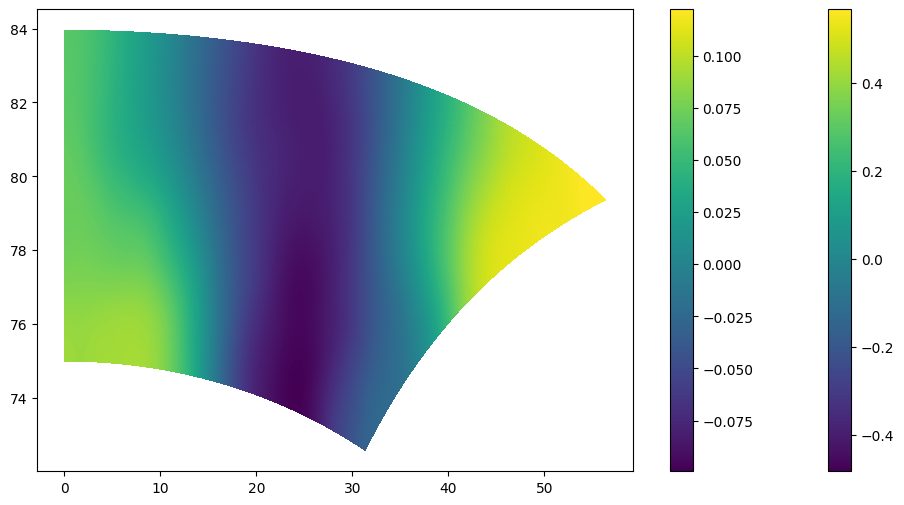

In [4]:
import wandb

import jax
import jax.numpy as jnp
from jax.lax import fori_loop, cond, scan
from jax import vmap, jit
from scipy.sparse import csc_matrix, identity
from scipy.sparse.linalg import cg, gmres
import math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import time


#Create mesh

r_earth = 6400.0  # in km; wavenumbers will be in 1/km
Lx = 1000  # km      Use 1020 and 1022 for dxm=4 and 2.
Ly = Lx
dxm = 5
dym = dxm
cyclic = 0  # 1 if mesh is cyclic
cyclic_length = 360  # in degrees; if not cyclic, take it larger than  zonal size
cyclic_length = cyclic_length * math.pi / 180  # DO NOT TOUCH
meshtype = 'm'  # coordinates can be in physical measure 'm' or in radians 'r'
cartesian = True

xx = np.arange(0, Lx + 1, dxm, dtype="float32")
yy = np.arange(0, Ly + 1, dym, dtype="float32")

# Create uniformity in the mesh
# xx = np.concatenate((np.arange(0, 4*Lx//20 + 1, dxm), np.arange(5*Lx//20, Lx + 1, dxm)))
# yy = np.concatenate((np.arange(0, 4*Ly//20 + 1, dym), np.arange(5*Ly//20, Ly + 1, dym)))

nx = len(xx)
ny = len(yy)

nodnum = np.arange(0, nx * ny)
xcoord = np.tile(xx, reps=(ny, 1)).T
ycoord = np.tile(yy, reps=(nx, 1))

#Create random data with given spectra

@jit
def make_ll(x, y):
    return jnp.sqrt(y * y + x * x)

@jit
def make_tff(ttf, ll):
    return ttf / (jnp.power(ll, 1.5))  # 1.5 for -2 spectrum

tt = 50 * (np.random.random(xcoord.shape) - 0.5)
ttf = np.fft.fft2(tt)
# ============
# Make spectrum red
# ============
espectrum = np.zeros((nx // 2 + 1))  # Place for Fourier spectrum
kk = np.concatenate((np.arange(0, nx // 2 + 1), np.arange(-nx // 2 + 1, 0, 1)))  # Wavenumbers

ll = vmap(vmap(make_ll, in_axes=(None, 0)), in_axes=(0, None))(kk, kk)
ttf = vmap(vmap(make_tff, in_axes=(0, 0)), in_axes=(0, 0))(ttf, ll)
ttf = ttf.at[0, 0].set(0.0)

tt = jnp.real(jnp.fft.ifft2(ttf))

# == == == == == == == =
# Reshape to 1D arrays
# == == == == == == == =
nodnum = np.reshape(nodnum, [ny, nx]).T
xcoord = np.reshape(xcoord, [nx * ny])
ycoord = np.reshape(ycoord, [nx * ny])
tt = np.reshape(tt, [nx * ny])

#Convert mesh and data to spherical geometry

cartesian = False

xcoord /= r_earth
ycoord /= r_earth
alpha = math.pi/3 + math.pi/12
zg = np.sin(ycoord)
xg = np.cos(ycoord) * np.cos(xcoord)
yg = np.cos(ycoord) * np.sin(xcoord)
# Rotate by alpha
zn = zg * np.cos(alpha) + xg * np.sin(alpha)
xg = -zg * np.sin(alpha) + xg * np.cos(alpha)
# New coordinates in radians
ycoord = np.arcsin(zn)
xcoord = np.arctan2(yg,xg)
# New coordinates in degrees
ycoord = (180/math.pi) * np.arcsin(zn)
xcoord = (180/math.pi) * np.arctan2(yg,xg)

#Create Triangulation

def make_tri(nodnum: jnp.ndarray, nx: int, ny: int):
    def make_tri(n, nn):
        return jnp.array([nodnum[nn, n], nodnum[nn+1, n], nodnum[nn, n+1]]), jnp.array([nodnum[nn+1, n], nodnum[nn+1, n+1], nodnum[nn, n+1]])

    b = jnp.reshape(vmap(lambda i: jnp.tile(i, nx-1))(jnp.arange(ny-1)), [(nx-1)*(ny-1)])
    a = jnp.tile(jnp.arange(nx-1), nx-1)

    tri = vmap(make_tri)(b, a)
    return jnp.reshape(jnp.concatenate((tri[0], tri[1]), axis=1), [2*(nx-1)*(ny-1), 3])

make_tri = jit(make_tri, static_argnums=[1, 2])

tri = make_tri(nodnum, nx, ny)
tri = np.array(tri)
n2d = len(xcoord)  # The number of vertices(nodes)
e2d = len(tri[:, 1])  # The number of triangles(elements)

tri

# Create auxilliary arrays for the 


def neighboring_triangles(n2d: int, e2d: int, tri: np.ndarray):
    """
    Calculate neighboring triangles for each node in a 2D mesh.

    Parameters:
    ----------
    n2d : int
        The total number of nodes in the mesh.

    e2d : int
        The total number of triangles (elements) in the mesh.

    tri : np.ndarray
        A 2D NumPy array representing the connectivity of triangles (elements) in the mesh.
        Each row contains the indices of the three nodes that form a triangle.

    Returns:
    -------
    ne_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the count of neighboring triangles for each node.

    ne_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_triangles, n2d) containing the positions of neighboring
        triangles for each node. The 'ne_pos[i, j]' entry indicates the index of the i-th neighboring triangle
        for the j-th node. Unused entries are filled with zeros.
    """
    # Initialize an array to store the count of neighboring triangles for each node.
    ne_num = np.zeros([n2d], dtype=int)

    # Loop through each triangle (element) in the mesh.
    for n in range(e2d):
        enodes = tri[n, :]
        # Increment the count of neighboring triangles for each node in the current triangle.
        ne_num[enodes] += 1

    # Initialize an array to store the positions of neighboring triangles for each node.
    ne_pos = np.zeros([int(np.max(ne_num)), n2d], dtype=int)

    # Reset the array to store the count of neighboring triangles for each node.
    ne_num = np.zeros([n2d], dtype=int)

    # Loop through each triangle (element) in the mesh.
    for n in range(e2d):
        enodes = tri[n, :]
        # Loop through the nodes of the current triangle.
        for j in range(3):
            # Store the position of the current neighboring triangle for the corresponding node.
            ne_pos[ne_num[enodes[j]], enodes[j]] = n
            # Increment the count of neighboring triangles for the node.
        ne_num[enodes] += 1

    return ne_num, ne_pos

def neighbouring_nodes(n2d: int, tri: np.ndarray, ne_num: np.ndarray, ne_pos: np.ndarray):
    """
    Compute neighboring nodes for each node in a 2D mesh.

    Parameters:
    ----------
    n2d : int
        The total number of nodes in the mesh.

    tri : np.ndarray
        A 2D NumPy array representing the connectivity of triangles (elements) in the mesh.
        Each row contains the indices of the three nodes that form a triangle.

    ne_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the count of neighboring triangles for each node.

    ne_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_triangles, n2d) containing the positions of neighboring
        triangles for each node. The 'ne_pos[i, j]' entry indicates the index of the i-th neighboring triangle
        for the j-th node. Unused entries are filled with zeros.

    Returns:
    -------
    nn_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the number of neighboring nodes for each node.

    nn_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_nodes, n2d) containing the positions of neighboring nodes
        for each node. The 'nn_pos[i, j]' entry indicates the index of the i-th neighboring node for the j-th node.
    """
    # Initialize an array to store the count of neighboring nodes for each node.


    # Initialize an array to store the positions of neighboring nodes for each node.
    nn_num = np.zeros([n2d], dtype=int)
    check = np.zeros([n2d], dtype=int)
    aux = np.zeros([10], dtype=int)
    for j in range(n2d):
        cc = 0
        for m in range(ne_num[j]):
            el = ne_pos[m, j]
            for k in range(3):
                a = tri[el, k]
                if check[a] == 0:
                    check[a] = 1
                    aux[cc] = a
                    cc += 1

        nn_num[j] = cc
        check[aux[0:cc]] = 0

    nn_pos = np.zeros([np.max(nn_num), n2d], dtype=int)

    for j in range(n2d):
        cc = 0
        for m in range(ne_num[j]):
            el = ne_pos[m, j]
            for k in range(3):
                a = tri[el, k]
                if check[a] == 0:
                    check[a] = 1
                    aux[cc] = a
                    cc += 1

        nn_pos[0:cc, j] = aux[0:cc].T
        check[aux[0:cc]] = 0

    return nn_num, nn_pos

def areas(n2d: int, e2d: int, tri: np.ndarray, xcoord: np.ndarray, ycoord: np.ndarray, ne_num: np.ndarray,
          ne_pos: np.ndarray, meshtype: str, carthesian: bool, cyclic_length):
    """
    Calculate areas of triangles and derivatives of P1 basis functions.

    Parameters:
    ----------
    n2d : int
        The total number of nodes in the mesh.

    e2d : int
        The total number of triangles (elements) in the mesh.

    tri : np.ndarray
        A 2D NumPy array representing the connectivity of triangles (elements) in the mesh.
        Each row contains the indices of the three nodes that form a triangle.

    xcoord : np.ndarray
        A 1D NumPy array containing the x-coordinates of nodes in the mesh.

    ycoord : np.ndarray
        A 1D NumPy array containing the y-coordinates of nodes in the mesh.

    ne_num : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the count of neighboring triangles for each node.

    ne_pos : np.ndarray
        A 2D NumPy array of shape (max_neighboring_triangles, n2d) containing the positions of neighboring
        triangles for each node. The 'ne_pos[i, j]' entry indicates the index of the i-th neighboring triangle
        for the j-th node. Unused entries are filled with zeros.

    meshtype : str
        Mesh type, either 'm' (metric) or 'r' (radial).

    carthesian : bool
        Boolean indicating whether the mesh is in Cartesian coordinates.

    cyclic_length : float
        The length of the cyclic boundary if the mesh is cyclic (for 'r' meshtype).

    Returns:
    -------
    area : np.ndarray
        A 1D NumPy array of shape (n2d,) containing the scalar cell (cluster) area for each node.

    elem_area : np.ndarray
        A 1D NumPy array of shape (e2d,) containing the area of each triangle (element) in the mesh.

    dx : np.ndarray
        A 2D NumPy array of shape (e2d, 3) containing the x-derivative of P1 basis functions for each triangle.

    dy : np.ndarray
        A 2D NumPy array of shape (e2d, 3) containing the y-derivative of P1 basis functions for each triangle.

    Mt : np.ndarray
        A 1D NumPy array of shape (e2d,) containing a factor for metric terms based on meshtype and coordinates.
    """
    dx = np.zeros([e2d, 3], dtype=float)
    dy = np.zeros([e2d, 3], dtype=float)
    elem_area = np.zeros([e2d])
    r_earth = 6400  # Earth's radius, assuming units in kilometers
    Mt = np.ones([e2d])

    if meshtype == 'm':
        for n in range(e2d):
            # Calculate differences in x and y coordinates for triangle vertices.
            x2 = xcoord[tri[n, 1]] - xcoord[tri[n, 0]]
            x3 = xcoord[tri[n, 2]] - xcoord[tri[n, 0]]
            y2 = ycoord[tri[n, 1]] - ycoord[tri[n, 0]]
            y3 = ycoord[tri[n, 2]] - ycoord[tri[n, 0]]

            # Calculate determinant of the Jacobian matrix for this triangle.
            d = x2 * y3 - y2 * x3

            # Calculate x and y derivatives of P1 basis functions.
            dx[n, 0] = (-y3 + y2) / d
            dx[n, 1] = y3 / d
            dx[n, 2] = -y2 / d

            dy[n, 0] = -(-x3 + x2) / d
            dy[n, 1] = -x3 / d
            dy[n, 2] = x2 / d

            # Calculate the area of the triangle.
            elem_area[n] = 0.5 * abs(d)

    elif meshtype == 'r':
        rad = math.pi / 180.0
        if carthesian:
            Mt = np.ones([e2d])
        else:
            Mt = np.cos(np.sum(rad * ycoord[tri], axis=1) / 3.0)

        for n in range(e2d):
            # Calculate differences in longitude and latitude for triangle vertices.
            x2 = rad * (xcoord[tri[n, 1]] - xcoord[tri[n, 0]])
            x3 = rad * (xcoord[tri[n, 2]] - xcoord[tri[n, 0]])
            y2 = r_earth * rad * (ycoord[tri[n, 1]] - ycoord[tri[n, 0]])
            y3 = r_earth * rad * (ycoord[tri[n, 2]] - ycoord[tri[n, 0]])

            # Adjust for cyclic boundaries.
            if x2 > cyclic_length / 2.0:
                x2 = x2 - cyclic_length
            if x2 < -cyclic_length / 2.0:
                x2 = x2 + cyclic_length
            if x3 > cyclic_length / 2.0:
                x3 = x3 - cyclic_length
            if x3 < -cyclic_length / 2.0:
                x3 = x3 + cyclic_length

            # Apply metric factors and calculate x and y derivatives of P1 basis functions.
            x2 = r_earth * x2 * Mt[n]
            x3 = r_earth * x3 * Mt[n]
            d = x2 * y3 - y2 * x3

            dx[n, 0] = (-y3 + y2) / d
            dx[n, 1] = y3 / d
            dx[n, 2] = -y2 / d

            dy[n, 0] = -(-x3 + x2) / d
            dy[n, 1] = -x3 / d
            dy[n, 2] = x2 / d

            # Calculate the area of the triangle.
            elem_area[n] = 0.5 * abs(d)

        if carthesian:
            Mt = np.zeros([e2d])
        else:
            Mt = (np.sin(rad * np.sum(ycoord[tri], axis=1) / 3.0) / Mt) / r_earth

    # Calculate scalar cell (cluster) area for each node.
    area = np.zeros([n2d])
    for n in range(n2d):
        area[n] = np.sum(elem_area[ne_pos[0:ne_num[n], n]]) / 3.0

    return area, elem_area, dx, dy, Mt

ne_num, ne_pos = neighboring_triangles(n2d, e2d, tri)
nn_num, nn_pos = neighbouring_nodes(n2d, tri, ne_num, ne_pos)
area, elem_area, dx, dy, Mt = areas(n2d, e2d, tri, xcoord, ycoord, ne_num, ne_pos, meshtype, cartesian, cyclic_length)

Kc = np.array([2, 2.2, 2.5, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 30, 40, 60, 80, 100]) * dxm
Kc = 2 * math.pi / Kc  # Wavenumbers
nr = len(Kc)

# Move data to JAX
jKc = jnp.array(Kc)
jescaling = jnp.zeros([nr + 1])  # Place for spectrum
# # Compute total energy
jescaling.at[0].set(jnp.sum(area * jnp.square(tt)) / jnp.sum(area))
jelem_area = jnp.array(elem_area)
jdx = jnp.array(dx)
jdy = jnp.array(dy)
jnn_num = jnp.array(nn_num)
jnn_pos = jnp.array(nn_pos)
jtri = jnp.array(tri)
jarea = jnp.array(area)
jMt = jnp.array(Mt)
jtt = jnp.array(tt)

# Create Laplacian matrix

def make_smooth(Mt: jnp.ndarray, elem_area: jnp.ndarray, dx: jnp.ndarray, dy: jnp.ndarray, nn_num: jnp.ndarray,
                nn_pos: jnp.ndarray, tri: jnp.ndarray, n2d: int, e2d: int, full: bool = False):
    """
    Calculate the smoothness matrix and metric matrix for a given mesh.

    WARNING!!! This function is inherently single-threaded!. Running it on GPU will cause performance issue

    Parameters:
    ----------
    Mt : jnp.ndarray
        A 1D JAX NumPy array containing metric factors for each triangle.

    elem_area : jnp.ndarray
        A 1D JAX NumPy array containing the area of each triangle.

    dx : jnp.ndarray
        A 2D JAX NumPy array of shape (e2d, 3) containing x-derivatives of P1 basis functions.

    dy : jnp.ndarray
        A 2D JAX NumPy array of shape (e2d, 3) containing y-derivatives of P1 basis functions.

    nn_num : jnp.ndarray
        A 1D JAX NumPy array of shape (n2d,) containing the number of neighboring nodes for each node.

    nn_pos : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing positions of neighboring nodes.

    tri : jnp.ndarray
        A 2D JAX NumPy array representing the connectivity of triangles in the mesh.

    n2d : int
        The total number of nodes in the mesh.

    e2d : int
        The total number of triangles (elements) in the mesh.

    full : bool, optional
        A flag indicating whether to use the 'full' calculation including metric factors (True) or not (False).
        Default is True.

    Returns:
    -------
    smooth_m : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing the smoothness matrix.

    metric : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing the metric matrix.
    """
    smooth_m = jnp.zeros(nn_pos.shape, dtype=jnp.float32)
    metric = jnp.zeros(nn_pos.shape, dtype=jnp.float32)
    aux = jnp.zeros((n2d,), dtype=jnp.int32)

    @jit
    def loop_body(j, carry):
        smooth_m, metric, aux, nn_num, nn_pos, elem_area, dx, dy, Mt = carry
        enodes = tri[j, :]

        def inner_loop_body(n, carry):
            smooth_m, metric, aux, enodes, nn_num, nn_pos, elem_area, dx, dy, Mt = carry
            row = enodes[n]
            cc = nn_num[row]

            def fill_xd(i, val):
                row, aux, nn_pos = val
                n = nn_pos[i, row]
                aux = aux.at[n].set(i)
                return row, aux, nn_pos

            row, aux, _ = fori_loop(0, cc, fill_xd, (row, aux, nn_pos))

            def update_smooth_m(m, carry):
                smooth_m, metric, aux, enodes, elem_area, dx, dy, n = carry
                col = enodes[m]
                pos = aux[col]
                tmp_x = dx[m] * dx[n]
                tmp_y = dy[n] * dy[m]
                c1 = m == n

                smooth_m = smooth_m.at[pos, row].add(cond(c1 & full,
                                                          lambda: (tmp_x + tmp_y) * elem_area + jnp.square(
                                                              Mt) * elem_area / 3.0,
                                                          lambda: (tmp_x + tmp_y) * elem_area
                                                          )
                                                     )
                metric = metric.at[pos, row].add(Mt * (dx[n] - dx[m]) * elem_area / 3.0)
                return smooth_m, metric, aux, enodes, elem_area, dx, dy, n

            smooth_m, metric, aux, _, _, _, _, _ = fori_loop(0, 3, update_smooth_m,
                                                             (smooth_m, metric, aux, enodes, elem_area, dx, dy, n))
            return smooth_m, metric, aux, enodes, nn_num, nn_pos, elem_area, dx, dy, Mt

        smooth_m, metric, aux, _, _, _, _, _, _, _ = fori_loop(0, 3, inner_loop_body, (
        smooth_m, metric, aux, enodes, nn_num, nn_pos, elem_area[j], dx[j, :], dy[j, :], Mt[j]))
        return smooth_m, metric, aux, nn_num, nn_pos, elem_area, dx, dy, Mt

    smooth_m, metric, _, _, _, _, _, _, _ = fori_loop(0, e2d, loop_body,
                                                      (smooth_m, metric, aux, nn_num, nn_pos, elem_area, dx, dy, Mt))
    return smooth_m, metric

@partial(jit, static_argnums=[3, 4])
def make_smat(nn_pos: jnp.ndarray, nn_num: jnp.ndarray, smooth_m: jnp.ndarray, n2d: int, nza: int):
    """
    Convert the smoothness matrix into a redundant sparse form (s(k), i(k), j(k)) as required by scipy.

    Parameters:
    ----------
    nn_pos : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing positions of neighboring nodes.

    nn_num : jnp.ndarray
        A 1D JAX NumPy array of shape (n2d,) containing the number of neighboring nodes for each node.

    smooth_m : jnp.ndarray
        A 2D JAX NumPy array of shape (max_neighboring_nodes, n2d) containing the smoothness matrix.

    n2d : int
        The total number of nodes in the mesh.

    nza : int
        The total number of nonzero elements.

    Returns:
    -------
    ss : jnp.ndarray
        A 1D JAX NumPy array of shape (nza,) containing the nonzero entries of the sparse matrix.

    ii : jnp.ndarray
        A 1D JAX NumPy array of shape (nza,) containing the row indices of the nonzero entries.

    jj : jnp.ndarray
        A 1D JAX NumPy array of shape (nza,) containing the column indices of the nonzero entries.
    """

    def helper(carry, x):
        n, m = carry
        out = (smooth_m[m, n], n, nn_pos[m, n])
        n, m = cond(m + 1 >= nn_num[n], lambda: cond(n + 1 >= n2d, lambda: (0, 0), lambda: (n + 1, 0)),
                    lambda: (n, m + 1))
        return (n, m), out

    _, tmp = scan(helper, init=(0, 0), xs=jnp.arange(nza))
    ss, ii, jj = tmp

    return ss, ii, jj

with jax.default_device(jax.devices("cpu")[0]): # Force JAX to use CPU
    jsmooth, metric = make_smooth(jMt, jelem_area, jdx, jdy, jnn_num, jnn_pos, jtri, n2d, e2d, False)
    ss, ii, jj = make_smat(jnn_pos, jnn_num, jsmooth, n2d, int(jnp.sum(jnn_num)))

# Maybe Here?

import torch
import torch.nn.functional as F
from torch.utils.data import IterableDataset
from torch.utils.data.dataloader import DataLoader
import os
import numpy as np
from tqdm import tqdm


class Arnoldi():
    def build(self, A, v0=None, m=100):

        n = A.shape[0]
        if v0 is None:
            v0 = torch.normal(0, 1, size=(n,), dtype=A.dtype).to(A.device)
        beta = torch.linalg.norm(v0)

        V = torch.zeros(n, m + 1, dtype=A.dtype).to(A.device)
        H = torch.zeros(m + 1, m, dtype=A.dtype).to(A.device)

        V[:, 0] = v0 / beta
        for j in range(m):
            w = A @ V[:, j]
            for k in range(j + 1):
                H[k, j] = torch.dot(V[:, k], w)
                w = w - H[k, j] * V[:, k]
            H[j + 1, j] = torch.linalg.norm(w)
            V[:, j + 1] = w / H[j + 1, j]

        Vm1 = V
        barHm = H
        return Vm1, barHm


# -----------------------------------------------------------------------------
# The following class implements a streaming dataset, which, in
# combined use with the dataloader, produces x of size (n,
# batch_size). x is float64 and stays in cpu. It will be moved to the
# device and cast to a lower precision for training.
class StreamingDataset(IterableDataset):

    # A is torch tensor, either sparse or full
    def __init__(self, A, batch_size, training_data, m):
        super().__init__()
        self.n = A.shape[0]
        self.m = m
        self.batch_size = batch_size
        self.training_data = training_data

        # Computations done in device
        if training_data == 'x_subspace' or training_data == 'x_mix':
            arnoldi = Arnoldi()
            Vm1, barHm = arnoldi.build(A, m=m)
            W, S, Zh = torch.linalg.svd(barHm, full_matrices=False)
            Q = (Vm1[:, :-1] @ Zh.T) / S.view(1, m)
            self.Q = Q.to('cpu')

    def generate(self):
        while True:

            # Computation done in cpu
            if self.training_data == 'x_normal':

                x = torch.normal(0, 1, size=(self.n, self.batch_size),
                                 dtype=torch.float64)
                yield x

            elif self.training_data == 'x_subspace':

                e = torch.normal(0, 1, size=(self.m, self.batch_size),
                                 dtype=torch.float64)
                x = self.Q @ e
                yield x

            elif self.training_data == 'x_mix':

                batch_size1 = self.batch_size // 2
                e = torch.normal(0, 1, size=(self.m, batch_size1),
                                 dtype=torch.float64)
                x = self.Q @ e
                batch_size2 = self.batch_size - batch_size1
                x2 = torch.normal(0, 1, size=(self.n, batch_size2),
                                  dtype=torch.float64)
                x = torch.cat([x, x2], dim=1)
                yield x

            else:  # self.training_data == 'no_x'

                b = torch.normal(0, 1, size=(self.n, self.batch_size),
                                 dtype=torch.float64)
                yield b

    def __iter__(self):
        return iter(self.generate())


# -----------------------------------------------------------------------------
# Graph neural preconditioner
class GNP():

    # A is torch tensor, either sparse or full
    def __init__(self, A, training_data, m, net, device):
        self.A = A
        self.training_data = training_data
        self.m = m
        self.net = net
        self.device = device
        self.dtype = net.dtype

    def train(self, batch_size, grad_accu_steps, epochs, optimizer,
              scheduler=None, num_workers=0, checkpoint_prefix_with_path=None,
              progress_bar=True):

        self.net.train()
        optimizer.zero_grad()
        dataset = StreamingDataset(self.A, batch_size,
                                   self.training_data, self.m)
        loader = DataLoader(dataset, num_workers=num_workers, pin_memory=True)

        hist_loss = []
        best_loss = np.inf
        best_epoch = -1
        checkpoint_file = None

        if progress_bar:
            pbar = tqdm(total=epochs, desc='Train')

        for epoch, x_or_b in enumerate(loader):

            # Generate training data
            if self.training_data != 'no_x':
                x = x_or_b[0].to(self.device)
                b = self.A @ x
                b, x = b.to(self.dtype), x.to(self.dtype)
            else:  # self.training_data == 'no_x'
                b = x_or_b[0].to(self.device).to(self.dtype)

            # Train
            x_out = self.net(b)
            b_out = (self.A @ x_out.to(torch.float64)).to(self.dtype)
            loss = F.l1_loss(b_out, b)

            wandb.log({
                        "loss": loss.item(),
                        "epoch": epoch,
                        "grad_norm": torch.nn.utils.clip_grad_norm_(self.net.parameters(), 1.0).item()
            })


            # Bookkeeping
            hist_loss.append(loss.item())
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_epoch = epoch
                if checkpoint_prefix_with_path is not None:
                    checkpoint_file = checkpoint_prefix_with_path + 'best.pt'
                    torch.save(self.net.state_dict(), checkpoint_file)

            # Train (cont.)
            loss.backward()
            if (epoch + 1) % grad_accu_steps == 0 or epoch == epochs - 1:
                optimizer.step()
                optimizer.zero_grad()
                if scheduler is not None:
                    scheduler.step()

            # Bookkeeping (cont.)
            if progress_bar:
                pbar.set_description(f'Train loss {loss:.1e}') #Both works for progress bars sometimes
                #pbar.set_postfix(loss=f"{loss.item():.2e}")   #This fixes it to one bar instead of each individual
                pbar.update()
            if epoch == epochs - 1:
                break

        # Bookkeeping (cont.)
        if checkpoint_file is not None:
            checkpoint_file_old = checkpoint_file
            checkpoint_file = \
                checkpoint_prefix_with_path + f'epoch_{best_epoch}.pt'
            os.rename(checkpoint_file_old, checkpoint_file)

        return hist_loss, best_loss, best_epoch, checkpoint_file

    @torch.no_grad()
    def apply(self, r):  # r: float64
        self.net.eval()
        # r = r.to(self.dtype)  # -> lower precision
        r = r.view(-1, 1)
        z = self.net(r)
        z = z.view(-1)
        # z = z.double()  # -> float64
        return z



import time
import torch
import numpy as np
from tqdm import tqdm
from warnings import warn

# Convention: M \approx inv(A)


#-----------------------------------------------------------------------------
# (Right-)Preconditioned generalized minimal residual method. Can use
# flexible preconditioner. Current implementation supports only a
# single right-hand side.
#
# If timeout is not None, max_iters is disabled.
class GMRES():

    def solve(self, A, b, M=None, x0=None, restart=10, max_iters=100,
              timeout=None, rtol=1e-8, progress_bar=True):

        if progress_bar:
            if timeout is None:
                pbar = tqdm(total=max_iters, desc='Solve')
                pbar.update()
            else:
                pbar = tqdm(desc='Solve')
                pbar.update()
                        
        if x0 is None:
            x = torch.zeros_like(b)
        else:
            x = x0
        norm_b = torch.linalg.norm(b)
        hist_abs_res = []
        hist_rel_res = []
        hist_time = []

        n = len(b)
        V = torch.zeros(n, restart+1, dtype=b.dtype).to(b.device)
        Z = torch.zeros(n, restart, dtype=b.dtype).to(b.device)
        H = torch.zeros(restart+1, restart, dtype=b.dtype).to(b.device)
        g = torch.zeros(restart+1, dtype=b.dtype).to(b.device)
        c = torch.zeros(restart, dtype=b.dtype).to(b.device)
        s = torch.zeros(restart, dtype=b.dtype).to(b.device)
        
        tic = time.time()

        # Initial step
        r = b - A @ x
        beta = torch.linalg.norm(r)
        abs_res = beta
        rel_res = abs_res / norm_b
        hist_abs_res.append(abs_res.item())
        hist_rel_res.append(rel_res.item())
        hist_time.append(time.time() - tic)
        iters = 0
        quit_iter = False

        # Outer loop
        while 1:

            # Restart cycle
            V[:,0] = r / beta
            g[0] = beta
            for j in range(restart):
                if M is not None:
                    Z[:,j] = M.apply(V[:,j])
                else:
                    Z[:,j] = V[:,j]
                w = A @ Z[:,j]
                for k in range(j+1):
                    H[k,j] = torch.dot(V[:,k], w)
                    w = w - H[k,j] * V[:,k]
                H[j+1,j] = torch.linalg.norm(w)
                V[:,j+1] = w / H[j+1,j]

                # Solve min || H * y - beta * e1 ||: Givens rotation
                for k in range(j):
                    tmp      =  c[k] * H[k,j] + s[k] * H[k+1,j]
                    H[k+1,j] = -s[k] * H[k,j] + c[k] * H[k+1,j]
                    H[k,j] = tmp
                t = torch.sqrt( H[j,j]**2 + H[j+1,j]**2 )
                c[j], s[j] = H[j,j]/t, H[j+1,j]/t
                H[j,j] = c[j] * H[j,j] + s[j] * H[j+1,j]
                H[j+1,j] = 0
                g[j+1] = -s[j] * g[j]
                g[j] = c[j] * g[j]
                # End solve min || H * y - beta * e1 ||: Givens rotation

                abs_res = torch.abs(g[j+1])
                rel_res = abs_res / norm_b
                hist_abs_res.append(abs_res.item())
                hist_rel_res.append(rel_res.item())
                hist_time.append(time.time() - tic)
                iters = iters + 1
                if (rel_res < rtol) or \
                   (timeout is None and iters == max_iters) or \
                   (timeout is not None and hist_time[-1] >= timeout):
                    quit_iter = True
                    break

                if progress_bar:
                    pbar.update()
            # End restart cycle

            # Solve min || H * y - beta * e1 ||: obtain solution
            y = torch.linalg.solve_triangular(H[:j+1, :j+1],
                                              g[:j+1].view(j+1,1),
                                              upper=True).view(j+1)
            # End solve min || H * y - beta * e1 ||: obtain solution

            x = x + Z[:, :j+1] @ y
            r = b - A @ x
            beta = torch.linalg.norm(r)
            if np.allclose(hist_abs_res[-1], beta.item()) is False:
                warn('Residual tracked by least squares solve is different '
                     'from the true residual. The result of GMRES should not '
                     'be trusted.')
            if quit_iter == True:
                break
            else:
                g = g.zero_()
                g[0] = beta
        # End outer loop

        if progress_bar:
            pbar.close()

        return x, iters, hist_abs_res, hist_rel_res, hist_time
            

#-----------------------------------------------------------------------------
# Arnoldi process (m steps).
class Arnoldi():

    def build(self, A, v0=None, m=100):

        n = A.shape[0]
        if v0 is None:
            v0 = torch.normal(0, 1, size=(n,), dtype=A.dtype).to(A.device)
        beta = torch.linalg.norm(v0)
        
        V = torch.zeros(n, m+1, dtype=A.dtype).to(A.device)
        H = torch.zeros(m+1, m, dtype=A.dtype).to(A.device)

        V[:,0] = v0 / beta
        for j in range(m):
            w = A @ V[:,j]
            for k in range(j+1):
                H[k,j] = torch.dot(V[:,k], w)
                w = w - H[k,j] * V[:,k]
            H[j+1,j] = torch.linalg.norm(w)
            V[:,j+1] = w / H[j+1,j]

        Vm1 = V
        barHm = H
        return Vm1, barHm
            

#-----------------------------------------------------------------------------
#if __name__ == '__main__':

    # Test Arnoldi
    #from GNP.problems import gen_1d_laplacian
    #A = gen_1d_laplacian(1000)
    #arnoldi = Arnoldi()
    #Vm1, barHm = arnoldi.build(A)
    #print( torch.linalg.norm( A @ Vm1[:,:-1] - Vm1 @ barHm ) )




import torch
from torch import nn
import torch.nn.functional as F
import numpy as np


def scale_A_by_spectral_radius(A):
    if A.layout == torch.sparse_csc:

        absA = torch.absolute(A)
        m, n = absA.shape
        row_sum = absA @ torch.ones(n, 1, dtype=A.dtype, device=A.device)
        col_sum = torch.ones(1, m, dtype=A.dtype, device=A.device) @ absA
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A * (1. / gamma.item())

    elif A.layout == torch.strided:

        absA = torch.absolute(A)
        row_sum = torch.sum(absA, dim=1)
        col_sum = torch.sum(absA, dim=0)
        gamma = torch.min(torch.max(row_sum), torch.max(col_sum))
        outA = A / gamma

    else:

        raise NotImplementedError(
            'A must be either torch.sparse_csc_tensor or torch.tensor')

    return outA


# -----------------------------------------------------------------------------
# An MLP layer.
class MLP(nn.Module):

    def __init__(self, in_dim, out_dim, num_layers, hidden, drop_rate,
                 use_batchnorm=False, is_output_layer=False, dtype=torch.float64):
        super().__init__()
        self.num_layers = num_layers
        self.use_batchnorm = use_batchnorm
        self.is_output_layer = is_output_layer

        self.lin = nn.ModuleList()
        self.lin.append(nn.Linear(in_dim, hidden, dtype=dtype))
        for i in range(1, num_layers - 1):
            self.lin.append(nn.Linear(hidden, hidden, dtype=dtype))
        self.lin.append(nn.Linear(hidden, out_dim, dtype=dtype))
        if use_batchnorm:
            self.batchnorm = nn.ModuleList()
            for i in range(0, num_layers - 1):
                self.batchnorm.append(nn.BatchNorm1d(hidden, dtype=dtype))
            if not is_output_layer:
                self.batchnorm.append(nn.BatchNorm1d(out_dim, dtype=dtype))
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, R):  # R: (*, in_dim)
        assert len(R.shape) >= 2
        for i in range(self.num_layers):
            R = self.lin[i](R)  # (*, hidden)
            if i != self.num_layers - 1 or not self.is_output_layer:
                if self.use_batchnorm:
                    shape = R.shape
                    R = R.view(-1, shape[-1])
                    R = self.batchnorm[i](R)
                    R = R.view(shape)
                R = self.dropout(F.relu(R))
                # (*, out_dim)
        return R


# -----------------------------------------------------------------------------
# A GCN layer.
class GCNConv(nn.Module):

    def __init__(self, AA, in_dim, out_dim, dtype=torch.float64):
        super().__init__()
        self.AA = AA  # normalized A
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.fc = nn.Linear(in_dim, out_dim, dtype=dtype)

    def forward(self, R):  # R: (n, batch_size, in_dim)
        assert len(R.shape) == 3
        n, batch_size, in_dim = R.shape
        assert in_dim == self.in_dim
        if in_dim > self.out_dim:
            R = self.fc(R)  # (n, batch_size, out_dim)
            R = R.view(n, batch_size * self.out_dim)  # (n, batch_size * out_dim)
            R = self.AA @ R  # (n, batch_size * out_dim)
            R = R.view(n, batch_size, self.out_dim)  # (n, batch_size, out_dim)
        else:
            R = R.view(n, batch_size * in_dim)  # (n, batch_size * in_dim)
            R = self.AA @ R  # (n, batch_size * in_dim)
            R = R.view(n, batch_size, in_dim)  # (n, batch_size, in_dim)
            R = self.fc(R)  # (n, batch_size, out_dim)
        return R


# -----------------------------------------------------------------------------
# GCN with residual connections.
class ResGCN(nn.Module):

    def __init__(self, A, num_layers, embed, hidden, drop_rate,
                 scale_input=True, dtype=torch.float64):
        # A: float64, already on device.
        #
        # For graph convolution, A will be normalized and cast to
        # lower precision and named AA.

        super().__init__()
        self.dtype = dtype  # used by GNP.precond.GNP
        self.num_layers = num_layers
        self.embed = embed
        self.scale_input = scale_input

        # Note: scale_A_by_spectral_radius() has been called when
        # defining the problem; hence, it is redundant. We keep the
        # code here to leave open the possibility of normalizing A in
        # another manner.
        self.AA = A.to(dtype)

        self.mlp_initial = MLP(1, embed, 4, hidden, drop_rate)
        self.mlp_final = MLP(embed, 1, 4, hidden, drop_rate,
                             is_output_layer=True, dtype=dtype)
        self.gconv = nn.ModuleList()
        self.skip = nn.ModuleList()
        self.batchnorm = nn.ModuleList()
        for i in range(num_layers):
            self.gconv.append(GCNConv(self.AA, embed, embed, dtype=dtype))
            self.skip.append(nn.Linear(embed, embed, dtype=dtype))
            self.batchnorm.append(nn.BatchNorm1d(embed, dtype=dtype))
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, r):  # r: (n, batch_size)
        assert len(r.shape) == 2
        n, batch_size = r.shape
        if self.scale_input:
            scaling = torch.linalg.vector_norm(r, dim=0) / np.sqrt(n)
            r = r / scaling  # scaling
        r = r.view(n, batch_size, 1)  # (n, batch_size, 1)
        R = self.mlp_initial(r)  # (n, batch_size, embed)

        for i in range(self.num_layers):
            R = self.gconv[i](R) + self.skip[i](R)  # (n, batch_size, embed)
            R = R.view(n * batch_size, self.embed)  # (n * batch_size, embed)
            R = self.batchnorm[i](R)  # (n * batch_size, embed)
            R = R.view(n, batch_size, self.embed)  # (n, batch_size, embed)
            R = self.dropout(F.relu(R))  # (n, batch_size, embed)

        z = self.mlp_final(R)  # (n, batch_size, 1)
        z = z.view(n, batch_size)  # (n, batch_size)
        if self.scale_input:
            z = z * scaling  # scaling back
        return z



#from GNP import GNP
#from ResGCN import ResGCN
#from GMRES import GMRES
#import torch

n = 1 # Filter order
device = torch.device("cuda")
solver = GMRES()
tmp = torch.tensor(np.array(ss) * (1.0 / np.square(Kc[-1])), device=device)
Smat1 = csc_matrix((ss * (1.0 / jnp.square(Kc[-1])), (ii, jj)), shape=(n2d, n2d))
Smat = identity(n2d) + 0.5 * (Smat1 ** n)

#Solve the problem

def jax_compute(ss, ii, jj, n2d, n, kl, ttu, tol=1e-6, maxiter=150000) -> np.ndarray:
    """
    Compute the filtered data using a specified filter size.

    Parameters:
    ------------
    n : int
        Order of filter, one is recommended

    k : float
        Wavelength of the filter.

    ttu : np.ndarray
        NumPy array containing data to be filtered.

    Returns:
    --------
    np.ndarray
        NumPy array with filtered data.
    """
    Smat1 = csc_matrix((ss * (1.0 / jnp.square(kl)), (ii, jj)), shape=(n2d, n2d))
    Smat = identity(n2d) + 0.5 * (Smat1 ** n)

    b = 1./ Smat.diagonal() # Simple preconditioner
    pre = csc_matrix((b, (np.arange(n2d), np.arange(n2d))), shape=(n2d, n2d))
    ttw = ttu - Smat @ ttu  # Work with perturbations
    iters = 0
    # Count number of iterations
    def nonlocal_iterate(arr):
        nonlocal iters
        iters+=1

    tts, code = cg(Smat, ttw, rtol=tol, maxiter=maxiter, M=pre, callback=nonlocal_iterate)
    if code != 0:
        print("Solver has not converged terms")

    print("Jax Iteration " + str(iters))

    tts += ttu
    return np.array(tts)

%time
tts = jax_compute(ss, ii, jj, n2d, 1, Kc[-1], tt)

import matplotlib as mpl

plt.rcParams['figure.figsize'] = [12, 6]
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triang, tt)
plt.colorbar()

plt.tripcolor(triang, tts)
plt.colorbar()

num_layers = 8              # number of layers in GNP
embed = 32                  # embedding dimension in GNP
hidden = 64                 # hidden dimension in MLPs in GNP
drop_rate = 0.1             # dropout rate in GNP
disable_scale_input = False # whether disable the scaling of inputs in GNP
dtype = torch.float64       # training precision for GNP
lr = 5e-3                   # learning rate in training GNP
weight_decay = 1e-4         # weight decay in training GNP
training_data = 'x_subspace'# type of training data x
m = 120                     # Krylov subspace dimension for training data
batch_size = 64             # batch size in training GNP
grad_accu_steps = 2         # gradient accumulation steps in training GNP
epochs = 3000               # number of epochs in training GNP

# Start a new run
import time
run_name = f"gnp-run-{time.strftime('%Y%m%d_%H%M')}"

wandb.init(
    project="GNP-training",
    entity="naomi-rill-alfred-wegener-institut",  # wandb user name
    name=run_name,  
    config={
        "learning_rate": lr,
        "batch_size": batch_size,
        "epochs": epochs,
        "num_layers": num_layers,
        "embed": embed,
        "hidden": hidden,
        "drop_rate": drop_rate,
        "training_data": training_data,
        "krylov_dim": m,
    }
)

A = torch.sparse_csc_tensor(Smat.indptr, Smat.indices, Smat.data, Smat.shape, dtype=torch.float64).to(device)
net = ResGCN(A, num_layers, embed, hidden, drop_rate, scale_input=True, dtype=dtype).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = None
M = GNP(A, training_data, m, net, device)

import time

tic = time.time()
hist_loss, best_loss, best_epoch, model_file = M.train(
    batch_size, grad_accu_steps, epochs, optimizer, scheduler, num_workers=4,
    checkpoint_prefix_with_path="./tmp_", progress_bar=True)

print(f'Done. Training time: {time.time()-tic} seconds')
print(f'Loss: inital = {hist_loss[0]}, final = {hist_loss[-1]}, best = {best_loss}, epoch = {best_epoch}')
print(f'Best model saved in {model_file}')

print(f'Loading model from {model_file} ...')
net.load_state_dict(torch.load(model_file, map_location=device, weights_only=True))
M = GNP(A, training_data, m, net, device)
print('Done.')

wandb.finish()


ttt = torch.tensor(np.array(tt), device=device, dtype=torch.float64)

#No Preconditioner

%time
ttw = ttt - A @ ttt  # Work with perturbations

x, iters, _, _, _ = solver.solve(A=A, b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False)
print("Classic Iteration " + str(iters))
x += ttt
tts = x.cpu().numpy()

#With Preconditioner

%time
ttw = ttt - A @ ttt  # Work with perturbations

x, iters, _, _, _ = solver.solve(A=A, b=ttw, rtol=1e-6, max_iters=20000, progress_bar=False, M=M)
print("Preconditioned Iteration " + str(iters))
x += ttt
tts = x.cpu().numpy()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Create synthetic data
def generate_data(n=1000):
    x = torch.linspace(-2, 2, n).unsqueeze(1)
    y = torch.sin(3 * x) + 0.3 * torch.randn_like(x)
    return x, y

# Preconditioner network
class Preconditioner(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

# Main solver network
class Solver(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Train function
def train(model, data_loader, loss_fn, optimizer, transform=None):
    model.train()
    total_loss = 0
    for x_batch, y_batch in data_loader:
        if transform:
            x_batch = transform(x_batch).detach()  # Apply preconditioner
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Evaluation
def evaluate(model, x, y, transform=None):
    model.eval()
    with torch.no_grad():
        if transform:
            x = transform(x)
        y_pred = model(x)
        return ((y_pred - y) ** 2).mean().item()

# Setup
x, y = generate_data()
dataset = TensorDataset(x, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
loss_fn = nn.MSELoss()

# Step 1: Train preconditioner alone
preconditioner = Preconditioner()
solver = Solver()
optimizer_pre = optim.Adam(preconditioner.parameters(), lr=0.01)

print("Training Preconditioner...")
for epoch in range(100):
    loss = train(preconditioner, loader, loss_fn, optimizer_pre)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Step 2: Train solver with frozen preconditioner
for param in preconditioner.parameters():
    param.requires_grad = False

optimizer_solver = optim.Adam(solver.parameters(), lr=0.01)
print("\nTraining Solver with frozen Preconditioner...")
for epoch in range(100):
    loss = train(solver, loader, loss_fn, optimizer_solver, transform=preconditioner)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Step 3: Joint fine-tuning (hierarchical stage)
for param in preconditioner.parameters():
    param.requires_grad = True

optimizer_joint = optim.Adam(list(preconditioner.parameters()) + list(solver.parameters()), lr=0.005)
print("\nFine-tuning Both (Hierarchical Training)...")
for epoch in range(100):
    loss = train(solver, loader, loss_fn, optimizer_joint, transform=preconditioner)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Final evaluation
final_loss = evaluate(solver, x, y, transform=preconditioner)
print(f"\nFinal Evaluation Loss: {final_loss:.4f}")


Training Preconditioner...
Epoch 0, Loss: 0.5147
Epoch 10, Loss: 0.2126
Epoch 20, Loss: 0.2013
Epoch 30, Loss: 0.1906
Epoch 40, Loss: 0.1934
Epoch 50, Loss: 0.1823
Epoch 60, Loss: 0.1824
Epoch 70, Loss: 0.1765
Epoch 80, Loss: 0.1874
Epoch 90, Loss: 0.1761

Training Solver with frozen Preconditioner...
Epoch 0, Loss: 0.2346
Epoch 10, Loss: 0.1234
Epoch 20, Loss: 0.1240
Epoch 30, Loss: 0.1203
Epoch 40, Loss: 0.1169
Epoch 50, Loss: 0.1157
Epoch 60, Loss: 0.1187
Epoch 70, Loss: 0.1176
Epoch 80, Loss: 0.1200
Epoch 90, Loss: 0.1154

Fine-tuning Both (Hierarchical Training)...
Epoch 0, Loss: 0.1145
Epoch 10, Loss: 0.1134
Epoch 20, Loss: 0.1130
Epoch 30, Loss: 0.1126
Epoch 40, Loss: 0.1119
Epoch 50, Loss: 0.1099
Epoch 60, Loss: 0.1101
Epoch 70, Loss: 0.1107
Epoch 80, Loss: 0.1108
Epoch 90, Loss: 0.1124

Final Evaluation Loss: 0.1118


Training baseline (non-hierarchical)...
Baseline Final MSE: 0.0220

Training preconditioner...
Training solver on preconditioned space...
Joint fine-tuning both (hierarchical training)...
Hierarchical Final MSE: 0.0112


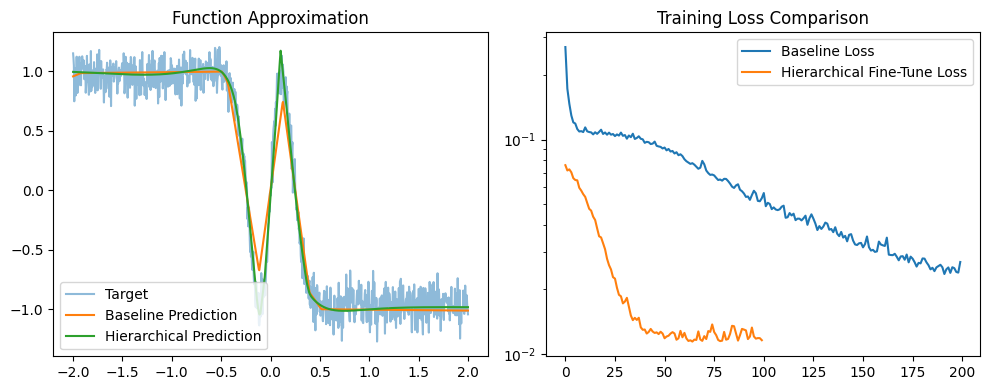

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set seed for reproducibility
torch.manual_seed(42)

# Generate synthetic data
def generate_data(n=1000):
    x = torch.linspace(-2, 2, n).unsqueeze(1)
    y = torch.sin(5 * torch.tanh(3 * x)) + 0.1 * torch.randn_like(x)
    return x, y

# Preconditioner 
class Preconditioner(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

# Solver 
class Solver(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Model 
class FullModel(nn.Module):
    def __init__(self, preconditioner, solver):
        super().__init__()
        self.pre = preconditioner
        self.sol = solver

    def forward(self, x):
        x = self.pre(x)
        return self.sol(x)

# Training function
def train(model, data_loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for x_batch, y_batch in data_loader:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Evaluation function
def evaluate(model, x, y):
    model.eval()
    with torch.no_grad():
        y_pred = model(x)
        return ((y_pred - y) ** 2).mean().item(), y_pred

# Prepare data
x, y = generate_data()
dataset = TensorDataset(x, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
loss_fn = nn.MSELoss()

### --- Non-Hierarchical Model (baseline) ---
baseline_model = Solver()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.01)

print("Training baseline (non-hierarchical)...")
baseline_losses = []
for epoch in range(200):
    loss = train(baseline_model, loader, loss_fn, optimizer_baseline)
    baseline_losses.append(loss)

mse_base, y_pred_base = evaluate(baseline_model, x, y)
print(f"Baseline Final MSE: {mse_base:.4f}")

### --- Hierarchical Training ---
# 1. Train preconditioner
pre = Preconditioner()
opt_pre = optim.Adam(pre.parameters(), lr=0.01)
print("\nTraining preconditioner...")
for epoch in range(100):
    loss = train(pre, loader, loss_fn, opt_pre)

# 2. Train solver on top (freeze pre)
sol = Solver()
for param in pre.parameters():
    param.requires_grad = False
full_model = FullModel(pre, sol)
opt_sol = optim.Adam(sol.parameters(), lr=0.01)
print("Training solver on preconditioned space...")
for epoch in range(100):
    loss = train(full_model, loader, loss_fn, opt_sol)

# 3. Joint fine-tuning
for param in pre.parameters():
    param.requires_grad = True
opt_joint = optim.Adam(full_model.parameters(), lr=0.005)
hierarchical_losses = []
print("Joint fine-tuning both (hierarchical training)...")
for epoch in range(100):
    loss = train(full_model, loader, loss_fn, opt_joint)
    hierarchical_losses.append(loss)

mse_hier, y_pred_hier = evaluate(full_model, x, y)
print(f"Hierarchical Final MSE: {mse_hier:.4f}")

### Plot Comparison 
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, y, label="Target", alpha=0.5)
plt.plot(x, y_pred_base, label="Baseline Prediction")
plt.plot(x, y_pred_hier, label="Hierarchical Prediction")
plt.title("Function Approximation")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_losses, label="Baseline Loss")
plt.plot(hierarchical_losses, label="Hierarchical Fine-Tune Loss")
plt.title("Training Loss Comparison")
plt.yscale("log")
plt.legend()

plt.tight_layout()
plt.show()
